### เฉลยแบบฝึกหัดที่ 6

---

จากการวิเคราะห์ การสร้าง linear regression model ในกลุ่มตัวอย่างที่ 1 (nicotine_addict=yes, bmi >= 30) หากทำการวิเคราะห์แบบเดียวกันในกลุ่มตัวอย่างที่ 2 (nicotine_addict=yes, bmi < 30) จะให้ผลสรุปเช่นเดียวกันหรือไม่ (mean R2 model1 < model2,  mean R2 model2 = mean R2 model3) จงแสดงวิธีการวิเคราะห์ทางสถิติ  
  
*หมายเหตุ*  
Model1 = Model using age only  
Model2 = Model using age + bmi  
Model3 = Model using age + bmi + sex + district  

In [ ]:
!pip install scikit_posthocs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scikit_posthocs as sp

&NewLine;  
#### <font color="color:#275bb0">**Read dataset**</font>

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ThammakornS/ProgStat/main/dataset/healthcare_cost.csv")
df.head()

,sex,age,bmi,nicotine_addict,district,healthcare_cost
0,female,21,27.900,yes,DT1,16884.92400
1,male,20,33.770,no,DT2,1725.55230
2,male,30,33.000,no,DT2,4449.46200
3,male,35,22.705,no,DT3,21984.47061
4,male,34,28.880,no,DT3,3866.85520


&NewLine;  
#### <font color="color:#275bb0">**Adjust data type**</font>

In [ ]:
df = df.astype({
    'sex': 'category',
    'nicotine_addict': 'category',
    'district': 'category'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sex              1338 non-null   category
 1   age              1338 non-null   int64   
 2   bmi              1338 non-null   float64 
 3   nicotine_addict  1338 non-null   category
 4   district         1338 non-null   category
 5   healthcare_cost  1338 non-null   float64 
dtypes: category(3), float64(2), int64(1)
memory usage: 35.8 KB


&nbsp;   
#### <font color="color:#275bb0">**Data groups**</font>

1.  nicotine_addict=yes, bmi \>= 30
2.  nicotine_addict=yes, bmi \< 30
3.  nicotine_addict=no

\
**Group 2**

In [ ]:
df_g2 = df.query('nicotine_addict == "yes" & bmi < 30')
print(df_g2.shape)
df_g2.head(10)

(129, 6)


,sex,age,bmi,nicotine_addict,district,healthcare_cost
0,female,21,27.900,yes,DT1,16884.92400
11,female,64,26.290,yes,DT2,27808.72510
52,male,50,28.000,yes,DT1,23568.27200
58,female,55,22.880,yes,DT2,23244.79020
64,female,22,22.420,yes,DT3,14711.74380
69,male,30,23.980,yes,DT2,17663.14420
70,female,29,24.750,yes,DT2,16577.77950
85,male,47,22.895,yes,DT3,21098.55405
92,male,61,29.830,yes,DT4,30184.93670
98,male,58,19.950,yes,DT4,22412.64850


&nbsp;   
#### <font color="color:#275bb0">**Removing outliers**</font>

<Axes: ylabel='healthcare_cost'>

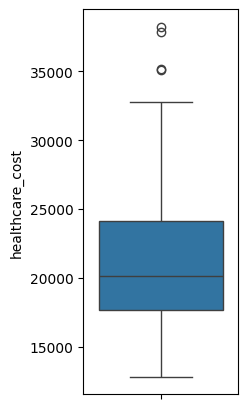

In [ ]:
fig, ax = plt.subplots(figsize=(2, 5))  #set size of plot (width, height)
sns.boxplot(data=df_g2,
            y="healthcare_cost",
            whis=1.5,
            ax=ax)

In [ ]:
q1, q3 = np.percentile(df_g2.healthcare_cost, [25, 75])
print("q1:", q1)
print("q3:", q3)
IQR = q3 - q1
print("IQR: ", IQR)
upper = df_g2.healthcare_cost[df_g2.healthcare_cost <= (q3 + 1.5*IQR)].max()
lower = df_g2.healthcare_cost[df_g2.healthcare_cost >= (q1 - 1.5*IQR)].min()
print("lower:",lower)
print("upper:",upper)

df_g2_remOut = df_g2[(df_g2.healthcare_cost < upper) &
                     (df_g2.healthcare_cost > lower)]
df_g2_remOut.shape

q1: 17663.1442
q3: 24106.91255
IQR:  6443.768350000002
lower: 12829.4551
upper: 32787.45859


(123, 6)

<Axes: ylabel='healthcare_cost'>

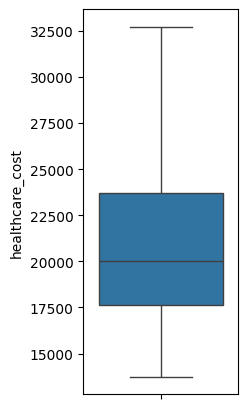

In [ ]:
fig, ax = plt.subplots(figsize=(2, 5))  #set size of plot (width, height)
sns.boxplot(data=df_g2_remOut,
            y="healthcare_cost",
            whis=1.5,
            ax=ax)

&nbsp;   
#### <font color="color:#1f7d02">*Comparison of Linear Regression Models*</font>

1. Model using age only
2. Model using age + bmi
3. Model using age + bmi + sex + district

\
Re-create feature and outcome data

In [ ]:
X = pd.concat([df_g2_remOut[['age','bmi']],
               pd.get_dummies(df_g2_remOut[['sex']], drop_first=True, dtype=int),
               pd.get_dummies(df_g2_remOut[['district']], drop_first=True, dtype=int)],
              axis=1)
X

,age,bmi,sex_male,district_DT2,district_DT3,district_DT4
0,21,27.900,0,0,0,0
11,64,26.290,0,1,0,0
52,50,28.000,1,0,0,0
58,55,22.880,0,1,0,0
64,22,22.420,0,0,1,0
...,...,...,...,...,...,...
1306,31,21.850,0,0,0,1
1307,34,28.120,1,0,1,0
1314,32,23.655,0,0,1,0
1321,64,26.695,1,0,0,1


In [ ]:
y = df_g2_remOut.filter(['healthcare_cost'])
y

,healthcare_cost
0,16884.92400
11,27808.72510
52,23568.27200
58,23244.79020
64,14711.74380
...,...
1306,16115.30450
1307,21472.47880
1314,18765.87545
1321,28101.33305


&nbsp;   
#### <font color="color:#275bb0">**1. Model using age only**</font>

In [ ]:
X1 = X.filter(['age'])
X1.head()

,age
0,21
11,64
52,50
58,55
64,22


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=1)
model = lr(fit_intercept=True)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('R2:', metrics.r2_score(y_test, y_pred_test))

MAE: 1377.8410673287954
MSE: 4654431.726711532
RMSE: 2157.4132025904382
R2: 0.709205237857174


\
Perform train-test split 100 times using 'random_state' from 0 to 99 and then collect performance results.

In [ ]:
perf_res = {}
perf_res['MAE']=[]
perf_res['MSE']=[]
perf_res['RMSE']=[]
perf_res['R2']=[]

for rs in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X1,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=rs)
    model = lr(fit_intercept=True)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)

    perf_res['MAE'].append(metrics.mean_absolute_error(y_test, y_pred_test))
    perf_res['MSE'].append(metrics.mean_squared_error(y_test, y_pred_test))
    perf_res['RMSE'].append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    perf_res['R2'].append(metrics.r2_score(y_test, y_pred_test))

perf1 = pd.DataFrame(perf_res)
perf1

,MAE,MSE,RMSE,R2
0,1388.629261,3.317717e+06,1821.460074,0.794611
1,1377.841067,4.654432e+06,2157.413203,0.709205
2,1684.077520,5.620240e+06,2370.704504,0.653600
3,1665.210265,7.808348e+06,2794.342174,0.646957
4,1548.127297,3.787401e+06,1946.124688,0.771652
...,...,...,...,...
95,1898.905895,1.050170e+07,3240.633102,0.484739
96,1451.448943,6.694678e+06,2587.407640,0.625462
97,1354.201328,2.986725e+06,1728.214439,0.810238
98,1558.319651,7.381479e+06,2716.887664,0.646398


In [ ]:
perf1.describe()

,MAE,MSE,RMSE,R2
count,100.000000,1.000000e+02,100.000000,100.000000
mean,1553.158191,5.349919e+06,2238.770475,0.688631
std,268.800563,2.807818e+06,584.155674,0.135047
min,990.205066,1.747675e+06,1321.996574,0.260959
25%,1369.576242,3.074506e+06,1753.395439,0.609284
50%,1523.696041,4.864207e+06,2205.479078,0.707255
75%,1685.570785,7.172227e+06,2678.072251,0.810474
max,2250.473287,1.205346e+07,3471.808925,0.901894


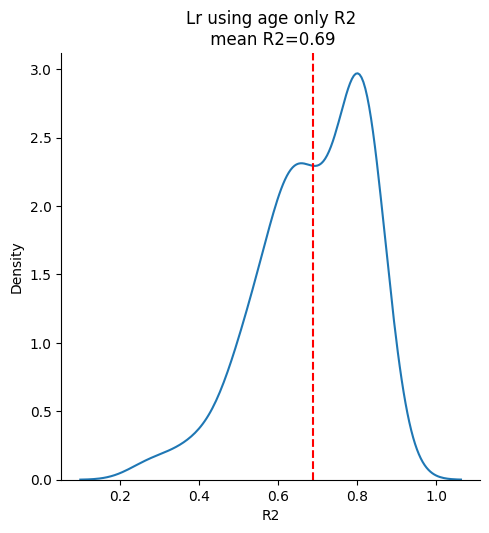

In [ ]:
sns.displot(perf1.R2, kind='kde')
plt.title(f"Lr using age only R2\n mean R2={perf1.R2.mean():.2f}")
plt.axvline(perf1.R2.mean(), c='r', ls='--')

In [ ]:
stats.shapiro(perf1.R2)

ShapiroResult(statistic=0.9326124986198648, pvalue=7.02332631495319e-05)

Shapiros's p-value < 0.05, indicates that R2 values are not normally distributed.

&nbsp;   
#### <font color="color:#275bb0">**2. Model using age + bmi**</font>

In [ ]:
X2 = X.filter(['age', 'bmi'])
X2.head()

,age,bmi
0,21,27.90
11,64,26.29
52,50,28.00
58,55,22.88
64,22,22.42


\
Perform train-test split 100 times using 'random_state' from 0 to 99 and then collect performance results.

In [ ]:
perf_res = {}
perf_res['MAE']=[]
perf_res['MSE']=[]
perf_res['RMSE']=[]
perf_res['R2']=[]

for rs in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X2,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=rs)
    model = lr(fit_intercept=True)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)

    perf_res['MAE'].append(metrics.mean_absolute_error(y_test, y_pred_test))
    perf_res['MSE'].append(metrics.mean_squared_error(y_test, y_pred_test))
    perf_res['RMSE'].append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    perf_res['R2'].append(metrics.r2_score(y_test, y_pred_test))

perf2 = pd.DataFrame(perf_res)
perf2

,MAE,MSE,RMSE,R2
0,893.846126,1.382256e+06,1175.693877,0.914429
1,954.911234,3.528185e+06,1878.346474,0.779570
2,1118.617513,3.869305e+06,1967.054938,0.761518
3,1220.775505,9.400998e+06,3066.104723,0.574948
4,1064.607249,1.769740e+06,1330.315905,0.893300
...,...,...,...,...
95,1461.092970,1.154226e+07,3397.389570,0.433685
96,1109.575813,8.374155e+06,2893.813186,0.531503
97,806.058252,1.530720e+06,1237.222676,0.902745
98,1021.866448,8.203645e+06,2864.200534,0.607014


In [ ]:
perf2.describe()

,MAE,MSE,RMSE,R2
count,100.000000,1.000000e+02,100.000000,100.000000
mean,1073.390726,4.432670e+06,1930.093675,0.751363
std,212.230010,3.745166e+06,845.312932,0.186638
min,730.709726,8.696261e+05,932.537448,0.195453
25%,909.715686,1.462778e+06,1209.452408,0.622109
50%,1051.775674,3.599090e+06,1897.070750,0.796972
75%,1169.729593,8.172206e+06,2858.705703,0.908730
max,1729.780446,1.365645e+07,3695.463404,0.951184


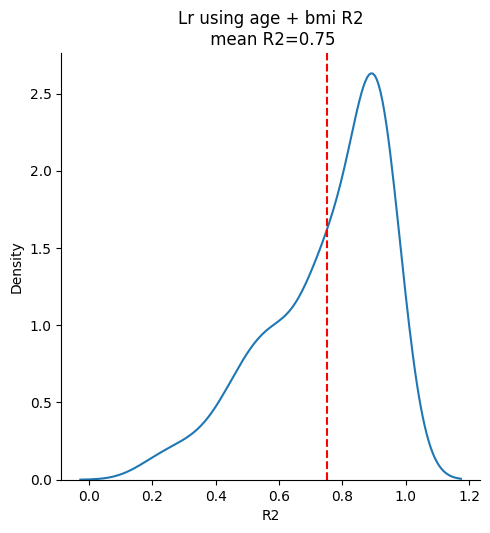

In [ ]:
sns.displot(perf2.R2, kind='kde')
plt.title(f"Lr using age + bmi R2\n mean R2={perf2.R2.mean():.2f}")
plt.axvline(perf2.R2.mean(), c='r', ls='--')

In [ ]:
stats.shapiro(perf2.R2)

ShapiroResult(statistic=0.8670676362580976, pvalue=5.3485505966685216e-08)

Shapiros's p-value < 0.05, indicates that R2 values are not normally distributed.

&nbsp;   
#### <font color="color:#275bb0">**3. Model using age + bmi + sex + district**</font>

In [ ]:
X3 = X
X3.head()

,age,bmi,sex_male,district_DT2,district_DT3,district_DT4
0,21,27.90,0,0,0,0
11,64,26.29,0,1,0,0
52,50,28.00,1,0,0,0
58,55,22.88,0,1,0,0
64,22,22.42,0,0,1,0


\
Perform train-test split 100 times using 'random_state' from 0 to 99 and then collect performance results.

In [ ]:
perf_res = {}
perf_res['MAE']=[]
perf_res['MSE']=[]
perf_res['RMSE']=[]
perf_res['R2']=[]

for rs in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X3,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=rs)
    model = lr(fit_intercept=True)
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)

    perf_res['MAE'].append(metrics.mean_absolute_error(y_test, y_pred_test))
    perf_res['MSE'].append(metrics.mean_squared_error(y_test, y_pred_test))
    perf_res['RMSE'].append(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    perf_res['R2'].append(metrics.r2_score(y_test, y_pred_test))

perf3 = pd.DataFrame(perf_res)
perf3

,MAE,MSE,RMSE,R2
0,1226.556508,2.327121e+06,1525.490311,0.855935
1,879.054885,3.472567e+06,1863.482482,0.783045
2,1203.688170,4.176015e+06,2043.529998,0.742614
3,1276.031695,9.227080e+06,3037.610928,0.582811
4,1003.433494,1.578000e+06,1256.184583,0.904860
...,...,...,...,...
95,1351.773226,1.118524e+07,3344.433444,0.451202
96,1084.174660,8.107827e+06,2847.424712,0.546402
97,848.542636,1.682056e+06,1296.941045,0.893130
98,1045.531252,7.933383e+06,2816.626139,0.619960


In [ ]:
perf3.describe()

,MAE,MSE,RMSE,R2
count,100.000000,1.000000e+02,100.000000,100.000000
mean,1121.123688,4.522024e+06,1967.745858,0.744831
std,199.819292,3.607821e+06,810.287258,0.179624
min,715.432714,7.528238e+05,867.654211,0.190186
25%,976.817953,1.663188e+06,1289.643814,0.634736
50%,1107.939117,3.627518e+06,1904.544639,0.789379
75%,1270.443150,7.943012e+06,2818.334386,0.893700
max,1685.347647,1.361026e+07,3689.208267,0.952529


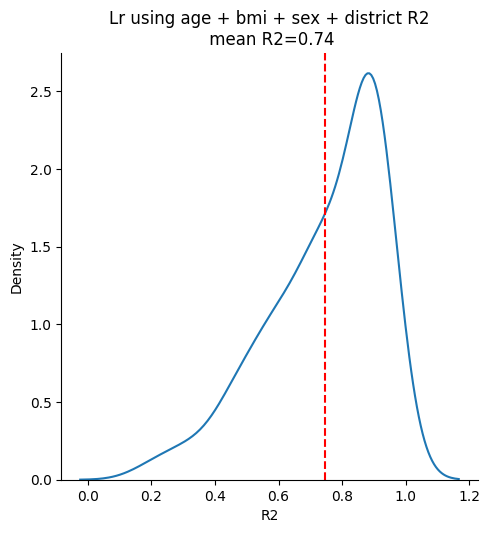

In [ ]:
sns.displot(perf3.R2, kind='kde')
plt.title(f"Lr using age + bmi + sex + district R2\n mean R2={perf3.R2.mean():.2f}")
plt.axvline(perf3.R2.mean(), c='r', ls='--')

In [ ]:
stats.shapiro(perf2.R2)

ShapiroResult(statistic=0.8670676362580976, pvalue=5.3485505966685216e-08)

Shapiros's p-value < 0.05, indicates that R2 values are not normally distributed.

&nbsp;   
#### <font color="color:#275bb0">**Compare all 3 R2s**</font>

\
Create dataframe for visualization

In [ ]:
df_R2s = pd.DataFrame({'Model1':perf1.R2,
                       'Model2':perf2.R2,
                       'Model3':perf3.R2
                      })
df_R2s_long = df_R2s.melt(value_vars=['Model1', 'Model2', 'Model3'],
                          value_name='R2',
                          var_name='Model')
df_R2s_long

,Model,R2
0,Model1,0.794611
1,Model1,0.709205
2,Model1,0.653600
3,Model1,0.646957
4,Model1,0.771652
...,...,...
295,Model3,0.451202
296,Model3,0.546402
297,Model3,0.893130
298,Model3,0.619960


\
Plot pdf

Text(0.5, 1.0, 'R2 Model1=0.69, Model2=0.75, Model3=0.74')

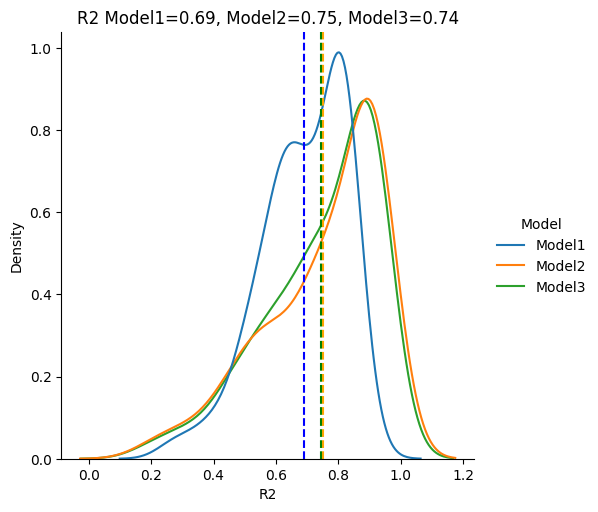

In [ ]:
sns.displot(data=df_R2s_long,
            x='R2',
            kind='kde',
            hue='Model')
plt.axvline(df_R2s.Model1.mean(), c='b', ls='--')
plt.axvline(df_R2s.Model2.mean(), c='orange', ls='--')
plt.axvline(df_R2s.Model3.mean(), c='g', ls='--')
plt.title(f"R2 Model1={df_R2s.Model1.mean():.2f}, Model2={df_R2s.Model2.mean():.2f}, Model3={df_R2s.Model3.mean():.2f}")

<Axes: xlabel='Model', ylabel='R2'>

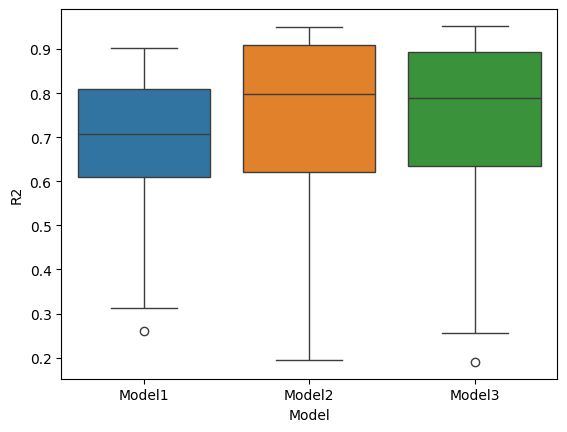

In [ ]:
sns.boxplot(data=df_R2s_long,
              x='Model',
              y='R2',
              hue='Model')

&nbsp;   
#### <font color="color:#275bb0">**Test of R2 means**</font>

Since all 3 data are not normally distributed, we will perform Kruskal–Wallis one-way analysis.

H<sub>0</sub>: there is no difference in the R2 means resulting from using model1, model2, or model3.  
H<sub>A</sub>: there is difference in the R2 means resulting from using model1, model2, or model3.

In [ ]:
f_score, p_value = stats.kruskal(df_R2s.Model1, df_R2s.Model2, df_R2s.Model3)
print("p-value:", p_value)

p-value: 0.00014326441134800065


p-value < 0.05, there is difference in the R2 means.

&nbsp;   
**Post hoc test**

In [ ]:
import scikit_posthocs as sp
sp.posthoc_conover(df_R2s_long, val_col='R2', group_col='Model')

,Model1,Model2,Model3
Model1,1.000000,0.000083,0.000681
Model2,0.000083,1.000000,0.576811
Model3,0.000681,0.576811,1.000000
